In [3]:
from notion2pandas import Notion2PandasClient
import sys
sys.path.append('../')
sys.path.append('../../')
import pandas as pd
import scresonators.measurement.handy as hy
import os 
#import scresonators.fit_resonator.ana_resonator as ana_res
#import scresonators.fit_resonator.ana_tls as ana_tls

import scipy.special as sp
import numpy as np 

eps_sil = 11.7 # silicon 
eps_sapp = 9.3 # sapphire 
rat_sil = 1.77 
rat_sapp = 2.39

eps_c = 10
delta = 0.003

def kp(k): return np.sqrt(1-k**2)
def Kp(k): return sp.ellipk(kp(k))
def K(k): return sp.ellipk(k)

def psm(a, b, eps):
    return eps**2 / eps_c/(eps+1) / (2 * (1-a/b)*Kp(a/b)*K(a/b)) * delta/a * (np.log(4*(1-a/b)/(1+a/b)) - a/b * np.log(a/b) / (1+a/b) + 1 - np.log(delta/a))

def psm2(pin, gap, eps):
    return psm(pin/2, pin/2+gap, eps)

pth_base ='/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/'
folder = 'My Drive/Projects/Materials/'
pth = pth_base+folder

img_pth = pth+'Outputs/Resonators/'
img_path = os.path.join(pth, 'Outputs/Resonators/')
yml_pth = os.path.join(pth, 'Outputs/Resonators/Text')
token = 'YOUR_NOTION_TOKEN_HERE'# Notion token
n2p = Notion2PandasClient(auth=token)

lnk = 'c2f3395c7ed34b3684c8b881290c5c7c' # Resonators notebook

## Sample params

In [4]:
p = '250602-ResSil7Ta_BFGsiliconta7_res1.yml'

name = 'Sil7-R2'
metal = 'Ta'
substrate='Silicon'
depo = 'sputterer'
notes = 'O3/BOE'
meas='VNA'
package = 'Slab'
date_meas = '2025-06-01'
Pattern = 'QcAdj_Sil'

## Create a data frame with new data 

In [7]:
# Now, make a df that has the same columns as the notion DB
cols=['freqs', 'pitch', 'qc', 'qc_err', 'qother', 'qtls0', 'qtls0_err', 'qother_err', 'target_freq']
yml_info=hy.load(os.path.join(yml_pth,p))
new_df = pd.DataFrame({col: yml_info[col] for col in cols})

time_dict =  {'start': date_meas, 'end': None, 'time_zone': None}
new_df['Date'] = new_df.apply(lambda row: time_dict, axis=1)
new_df['Metal'] = metal
new_df['Substrate'] = substrate
new_df['Depo']=depo
new_df['Package']=package
new_df['Measurement']=meas
new_df['Notes'] = notes
new_df['PageID']=''
new_df['Row_Hash']=''
new_df['Fridge Cool Down']=''
new_df['Name']=name
new_df['Samples']=''
new_df['Pattern']=Pattern

new_df.rename(columns={'pitch': 'Gap (um)', 'qtls0': 'QTLS0 (1e6)', 'qother': 'Qother (1e6)', 'qother_err':'Qother err (1e6)', 'qc':'Qc (1e6)', 'qc_err':'Qc err (1e6)','qtls0_err':'QTLS0 err (1e6)', 'target_freq':'Target Freq. (GHz)', 'freqs':'Freq (GHz)' }, inplace=True)
round_cols = ['QTLS0 (1e6)', 'Qother (1e6)', 'Qc (1e6)', 'Qc err (1e6)', 'QTLS0 err (1e6)', 'Qother err (1e6)']
new_df[round_cols] = new_df[round_cols] / 1e6
new_df['Freq (GHz)'] = new_df['Freq (GHz)'] / 1e9

new_df[round_cols] = new_df[round_cols].round(4)
f_cols = ['Freq (GHz)', 'Target Freq. (GHz)']
new_df[f_cols] = new_df[f_cols].round(7)

new_df['Pin (um)'] = new_df.apply(
    lambda row: row['Gap (um)'] * rat_sapp if row['Substrate'] == 'Sapphire' else row['Gap (um)'] * rat_sil,
    axis=1
)

new_df['Pin (um)'] = new_df.apply(
    lambda row: row['Gap (um)'] if row['Gap (um)'] in [3, 30] else row['Pin (um)'],
    axis=1
)

new_df['P_ms'] = new_df.apply(
    lambda row: psm2(row['Pin (um)'], row['Gap (um)'], eps_sapp if row['Substrate'] == 'Sapphire' else eps_sil),
    axis=1
)

In [8]:
new_df

,Freq (GHz),Gap (um),Qc (1e6),Qc err (1e6),Qother (1e6),QTLS0 (1e6),QTLS0 err (1e6),Qother err (1e6),Target Freq. (GHz),Date,...,Measurement,Notes,PageID,Row_Hash,Fridge Cool Down,Name,Samples,Pattern,Pin (um),P_ms
0,8.017990,3,17.5976,0.3812,0.4809,0.4145,0.0463,0.0066,8.033,"{'start': '2025-06-01', 'end': None, 'time_zon...",...,VNA,O3/BOE,,,,Sil7-R2,,QcAdj_Sil,3.00,0.002683
1,7.026331,4,1.9513,0.0147,0.3353,0.7854,0.1005,0.0026,7.041,"{'start': '2025-06-01', 'end': None, 'time_zon...",...,VNA,O3/BOE,,,,Sil7-R2,,QcAdj_Sil,7.08,0.001632
2,7.247000,8,0.7507,0.0030,0.1625,0.3997,0.1344,0.0008,7.236,"{'start': '2025-06-01', 'end': None, 'time_zon...",...,VNA,O3/BOE,,,,Sil7-R2,,QcAdj_Sil,14.16,0.000881
3,6.004001,20,0.1908,0.0005,1.5969,1.5936,0.1462,0.0230,5.996,"{'start': '2025-06-01', 'end': None, 'time_zon...",...,VNA,O3/BOE,,,,Sil7-R2,,QcAdj_Sil,35.40,0.000387
4,6.328492,24,0.4700,0.0014,0.7613,1.9587,0.1621,0.0047,6.320,"{'start': '2025-06-01', 'end': None, 'time_zon...",...,VNA,O3/BOE,,,,Sil7-R2,,QcAdj_Sil,42.48,0.000328
5,6.681213,28,0.4823,0.0016,0.2155,1.1589,0.5105,0.0022,6.671,"{'start': '2025-06-01', 'end': None, 'time_zon...",...,VNA,O3/BOE,,,,Sil7-R2,,QcAdj_Sil,49.56,0.000285
6,7.604976,30,0.1691,0.0003,0.1106,1.2188,0.3800,0.0005,7.607,"{'start': '2025-06-01', 'end': None, 'time_zon...",...,VNA,O3/BOE,,,,Sil7-R2,,QcAdj_Sil,30.00,0.000344


## Load notion database as dataframe and add new data to it 

In [9]:
notion_df = n2p.from_notion_DB_to_dataframe(lnk)
combined_df = pd.concat([notion_df, new_df], ignore_index=True)
#print(combined_df)

## Send updated df to notion

In [10]:
n2p.update_notion_DB_from_dataframe(lnk, combined_df)

In [ ]:
notion_df = n2p.from_notion_DB_to_dataframe(lnk)

In [3]:
import scipy.special as sp
import numpy as np 

eps_sil = 11.7 # silicon 
eps_sapp = 9.3 # sapphire 
rat_sil = 1.77 
rat_sapp = 2.39

eps_c = 10
delta = 0.003

def kp(k): return np.sqrt(1-k**2)
def Kp(k): return sp.ellipk(kp(k))
def K(k): return sp.ellipk(k)

def psm(a, b, eps):
    return eps**2 / eps_c/(eps+1) / (2 * (1-a/b)*Kp(a/b)*K(a/b)) * delta/a * (np.log(4*(1-a/b)/(1+a/b)) - a/b * np.log(a/b) / (1+a/b) + 1 - np.log(delta/a))

def psm2(pin, gap, eps):
    return psm(pin/2, pin/2+gap, eps)

In [ ]:
# Fill in values for 'Pin (um)' in notion_df based on the substrate
notion_df['Pin (um)'] = notion_df.apply(
    lambda row: row['Gap (um)'] * rat_sapp if row['Substrate'] == 'Sapphire' else row['Gap (um)'] * rat_sil,
    axis=1
)

notion_df['Pin (um)'] = notion_df.apply(
    lambda row: row['Gap (um)'] if row['Gap (um)'] in [3, 30] else row['Pin (um)'],
    axis=1
)

In [9]:
notion_df['P_ms'] = notion_df.apply(
    lambda row: psm2(row['Pin (um)'], row['Gap (um)'], eps_sapp if row['Substrate'] == 'Sapphire' else eps_sil),
    axis=1
)

In [19]:
notion_df['Pattern'] = notion_df['Name'].apply(
    lambda x: 'Houck_Sapp' if x == 'Sil1_SQ' else ('QcAdj_Sil' if x == 'Sil7-R1' else 'Houck_Sil')
)

In [20]:
n2p.update_notion_DB_from_dataframe(lnk, notion_df)

# Plots (can run independently of first part)

IndexError: list index out of range

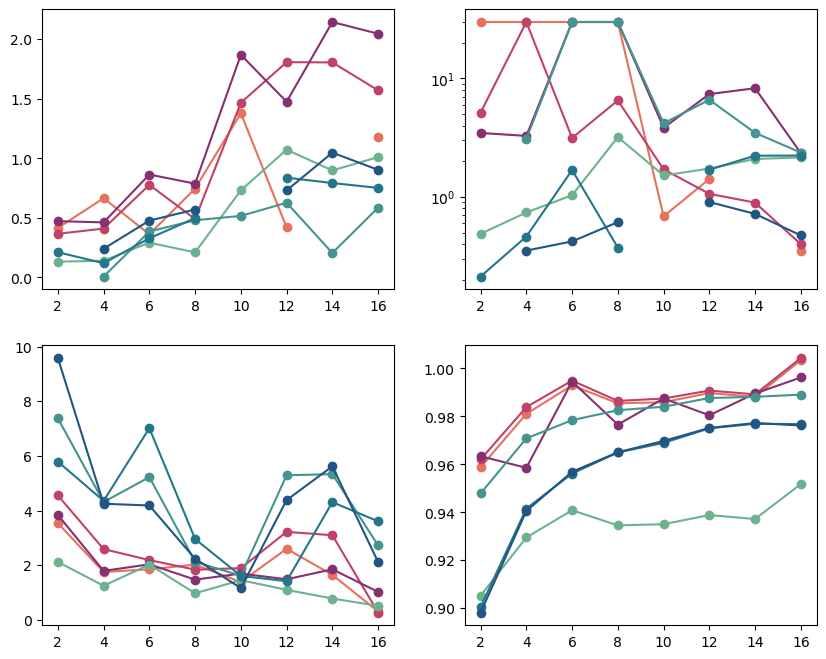

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime

notion_df = n2p.from_notion_DB_to_dataframe(lnk)

colors = ["#0869c8","#b51d14", '#ddb310','#658b38','#7e1e9c', '#75bbfd', '#cacaca']
sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(2,2, figsize=(10,8))
ax = ax.flatten()
xval = 'Gap (um)'
#xval = 'Target Freq. (GHz)'
num_sapp = 3
num_sil = 4 
b1 = sns.color_palette('flare',num_sapp)
b2 = sns.color_palette('crest',num_sil)
col = b1+b2
i=0
num_sets = len(notion_df['Name'].unique())
for name, group in notion_df.groupby('Name'):
    
    group = group.sort_values(by=xval)
    #print(f"Group: {name}")
    #print(group['Gap (um)'])
    ax[0].plot(group[xval], group['QTLS0 (1e6)'], 'o-', label=name, color=col[i])
    ax[1].semilogy(group[xval], group['Qother (1e6)'], 'o-', label=name, color=col[i])
    ax[2].plot(group[xval], group['Qc (1e6)'], 'o-', label=name, color=col[i])
    ax[3].plot(group[xval], group['Freq (GHz)']/group['Target Freq. (GHz)'], 'o-', label=name, color=col[i])
    #ax[3].plot(group[xval], group['Freq (GHz)'], 'o-', label=name)
    i+=1
ax[0].legend()
ax[0].set_ylabel('$Q_{TLS,0}$ (1e6)')
ax[1].set_ylabel('$Q_{\mathrm{other}}$ (1e6)')
ax[2].set_ylabel('$Q_{c}$ (1e6)')
ax[3].set_ylabel('Freq. Ratio')
for a in ax: 
    a.set_xlabel(xval)
fig.tight_layout()
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
fig.savefig(f"resonators_{current_time}.png")

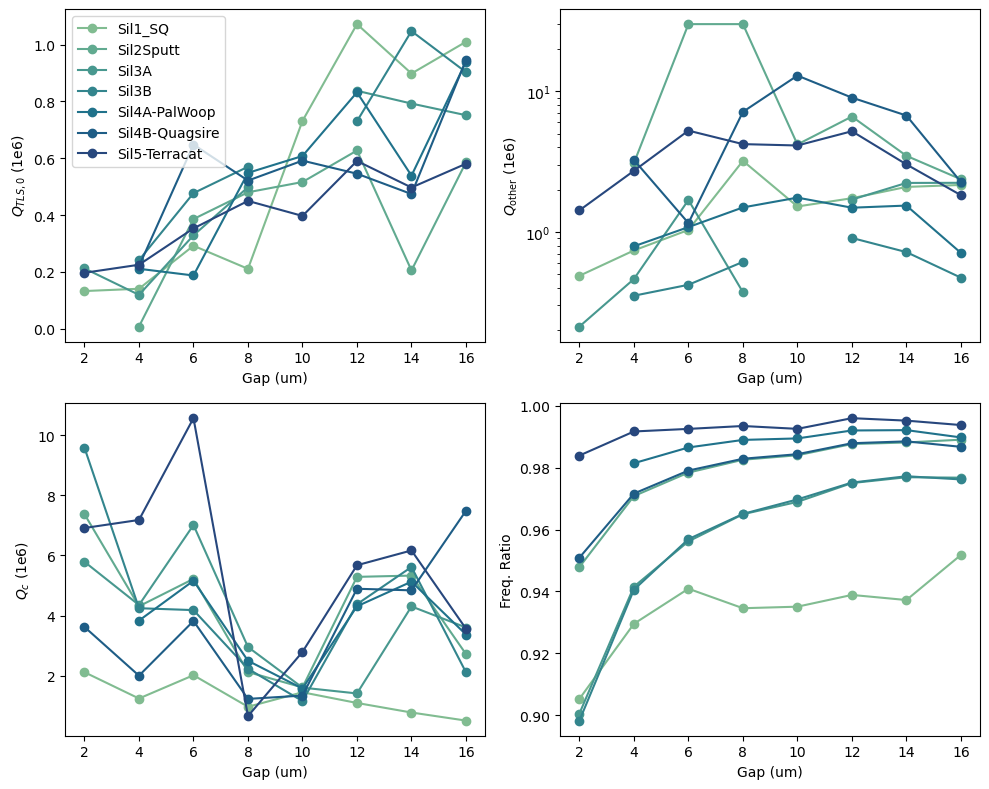

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime

notion_df = n2p.from_notion_DB_to_dataframe(lnk)

colors = ["#0869c8","#b51d14", '#ddb310','#658b38','#7e1e9c', '#75bbfd', '#cacaca']
sns.set_palette(sns.color_palette(colors))

fig, ax = plt.subplots(2,2, figsize=(10,8))
ax = ax.flatten()
xval = 'Gap (um)'
#xval = 'Target Freq. (GHz)'
num_sapp = 3
num_sil = 7
#b1 = sns.color_palette('flare',num_sapp)
b2 = sns.color_palette('crest',num_sil)
col = b1+b2
col = b2
i=0
num_sets = len(notion_df['Name'].unique())
for name, group in notion_df.groupby('Name'):
    if group['Substrate'].iloc[0]=='Silicon':
        group = group.sort_values(by=xval)
        #print(f"Group: {name}")
        #print(group['Gap (um)'])
        ax[0].plot(group[xval], group['QTLS0 (1e6)'], 'o-', label=name, color=col[i])
        ax[1].semilogy(group[xval], group['Qother (1e6)'], 'o-', label=name, color=col[i])
        ax[2].plot(group[xval], group['Qc (1e6)'], 'o-', label=name, color=col[i])
        ax[3].plot(group[xval], group['Freq (GHz)']/group['Target Freq. (GHz)'], 'o-', label=name, color=col[i])
        #ax[3].plot(group[xval], group['Freq (GHz)'], 'o-', label=name)
        i+=1
ax[0].legend()
ax[0].set_ylabel('$Q_{TLS,0}$ (1e6)')
ax[1].set_ylabel('$Q_{\mathrm{other}}$ (1e6)')
ax[2].set_ylabel('$Q_{c}$ (1e6)')
ax[3].set_ylabel('Freq. Ratio')
for a in ax: 
    a.set_xlabel(xval)
fig.tight_layout()
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
fig.savefig(f"resonators_{current_time}.png")

### They need to have all the same rows and columns

In [76]:
#print(notion_df.columns)
#print(new_df.columns)

common_columns = notion_df.columns.intersection(new_df.columns)
print("Common columns:", common_columns)

notion_only_columns = notion_df.columns.difference(new_df.columns)
print("Columns only in notion_df:", notion_only_columns)

new_df_only_columns = new_df.columns.difference(notion_df.columns)
print("Columns only in new_df:", new_df_only_columns)

Common columns: Index(['Gap (um)', 'Target Freq. (GHz)', 'Qother (1e6)', 'Measurement',
       'Notes', 'Freq (GHz)', 'Package', 'Qother err (1e6)', 'Qc err (1e6)',
       'Samples', 'QTLS0 (1e6)', 'Fridge Cool Down', 'Depo', 'QTLS0 err (1e6)',
       'Qc (1e6)', 'Date', 'Metal', 'Substrate', 'Name', 'PageID', 'Row_Hash'],
      dtype='object')
Columns only in notion_df: Index([], dtype='object')
Columns only in new_df: Index([], dtype='object')
